In [92]:
import os 
import json
import tweepy
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Twitter API credentials from external file

Create a json file named `twitter_credentials.json`

```
{
    "api_key": "...",
    "api_secret": "...",
    "access_token": "...",
    "access_secret": "...",
    "bearer_token": "..."
}
```

In [65]:
credentials_file = 'twitter_credentials.json'

with open(credentials_file) as credentials_data:
   api_data = json.load(credentials_data)

api_key = api_data['api_key']
api_secret = api_data['api_secret']
access_token = api_data['access_token']
access_secret = api_data['access_secret']
bearer_token = api_data['bearer_token']

In [66]:

client = tweepy.Client(
    consumer_key=api_key, 
    consumer_secret=api_secret, 
    access_token=access_token, 
    access_token_secret=access_secret, 
    bearer_token=bearer_token,
    wait_on_rate_limit=True,
    return_type=dict
)

In [72]:
accounts = ["mizzaro", "Miccighel_"]
data_folder = "data"
excluded_users_file = "excluded_usernames.json"
existing_accounts = ["mizzaro", "Miccighel_"]

def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}", 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

def read_json(path, verbose=True):
    if os.path.exists(path):
        with open(path, "r", encoding="utf8") as file:
            data = json.load(file)
        if verbose:
            print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

# check if username is excluded
def is_excluded(username):
    excluded_users_data = read_json(f"{data_folder}/{excluded_users_file}", False)
    excluded_users_list = excluded_users_data['excluded']

    if username in excluded_users_list:
        return True
    else:
        return False

# add username to excluded lists
def add_to_excluded(username):
    excluded_users_data = read_json(f"{data_folder}/{excluded_users_file}", False)
    excluded_users_list = excluded_users_data['excluded']

    if username not in excluded_users_list:
        excluded_users_data['excluded'].append(username)
        serialize_json(data_folder, excluded_users_file, excluded_users_data)
    else:
        print(f"User {username} is already present in excluded list")

# check if username is already present
def is_present(username):
    if username in existing_accounts:
        return True
    else:
        return False

# add username to existing lists
def add_to_existing(username):
    if username not in existing_accounts:
        existing_accounts.append(username)
    else:
        print(f"User {username} is already present in existing list")

# add to existing list from json file
def add_to_existing_from_file(filename):
    accounts_list = read_json(filename)
    for account in accounts_list:
       add_to_existing(account['username'])

def get_tweetsv2(username, quantity, userid=None):
    tweets = []
    tweets_file = f"{data_folder}/{username}_tweets.json"

    data_total = quantity

    if not os.path.exists(tweets_file):
        # Get Tweets from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get 5 most recent tweets
        response = client.get_users_tweets(
                    id=user['id'], tweet_fields=['created_at', 'lang', 'public_metrics'],
                    max_results=data_total
                    )
    else:
        # Get Tweets from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(tweets_file)
    
    for data in response['data']:
        tweets.append(data)
    return tweets

def get_followersv2(username, quantity, userid=None, save_all=True):
    followers_of_user = []
    all_followers_of_user = []
    all_followers_file = f"{data_folder}/{username}_followers.json"

    data_for_page = 1000
    data_total = quantity

    if not os.path.exists(all_followers_file):
        # Get Followers from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get first 1000 followers
        response = client.get_users_followers(
                    id=user['id'], user_fields=['name', 'description', 'location', 'protected', 'public_metrics'], 
                    max_results=data_for_page
                    )
    else:
        # Get Followers from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(all_followers_file)
        save_all = False
    
    for data in response['data']:
        if save_all:
            all_followers_of_user.append(data)
        # Skip excluded username or already present accounts:
        if is_excluded(data['username']) or is_present(data['username']):
            continue
        if(len(followers_of_user) < data_total) and\
            not data['protected'] and\
            data['public_metrics']['tweet_count'] >= 5 and\
            5 <= data['public_metrics']['followers_count'] < 1000 and\
            5 <= data['public_metrics']['following_count'] < 1000:
            followers_of_user.append(data)
            add_to_existing(data['username'])
    if save_all:                
        serialize_json(data_folder, f"{username}_followers.json", all_followers_of_user)
    print(f"Found {len(followers_of_user)} followers for user {username}")
    if len(followers_of_user) < data_total:
        add_to_excluded(username)
        return []
    else:
        return followers_of_user

def get_followingv2(username, quantity, userid=None, save_all=False):
    following_of_user = []
    all_following_of_user = []
    all_following_file = f"{data_folder}/{username}_following.json"

    data_for_page = 1000
    data_total = quantity

    if not os.path.exists(all_following_file):
        # Get Following from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get first 1000 following
        response = client.get_users_following(
                    id=user['id'], user_fields=['protected', 'public_metrics'], 
                    max_results=data_for_page
                    )
    else:
        # Get Following from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(all_following_file)
        save_all = False
    
    for data in response['data']:
        if save_all:
            all_following_of_user.append(data)
        # Skip excluded username or already present accounts:
        if is_excluded(data['username']) or is_present(data['username']):
            continue
        if(len(following_of_user) < data_total) and\
            not data['protected'] and\
            data['public_metrics']['tweet_count'] >= 5 and\
            5 <= data['public_metrics']['followers_count'] < 1000 and\
            5 <= data['public_metrics']['following_count'] < 1000:
            following_of_user.append(data)
            add_to_existing(data['username'])
    if save_all:                
        serialize_json(data_folder, f"{username}_following.json", all_following_of_user)
    print(f"Found {len(following_of_user)} following of user {username}")
    if len(following_of_user) < data_total:
        add_to_excluded(username)
        return []
    else:
        return following_of_user

# Root level accounts details

In [84]:
if not os.path.exists(f"{data_folder}/root_level_accounts.json"):
    # get root accounts details 
    response = client.get_users(usernames=accounts, user_fields=['name', 'description', 'location', 'protected', 'public_metrics'])
    serialize_json(data_folder, "root_level_accounts.json", response['data'])

# First level followers

In [73]:

if not os.path.exists(f"{data_folder}/first_level_followers.json"):
    first_level_followers = []
    for account in accounts:
        # Get 5 followers and save all followers list
        first_level_followers.extend(get_followersv2(account, 5))
    
    serialize_json(data_folder, "first_level_followers.json", first_level_followers)
else:
    # add to existing list
    add_to_existing_from_file(f"{data_folder}/first_level_followers.json")

Data read from path: data/first_level_followers.json
['mizzaro', 'Miccighel_', 'OlegZendel', 'LyndaSaidLhadj', 'acai2021', 'rodger_benham', 'ColoursRiot', 'Outsider289', 'EUROARTISTS', 'VincenzoCarli15', 'Ilele99', 'ChriShot90']


# First level following

In [74]:
if not os.path.exists(f"{data_folder}/first_level_following.json"):
    first_level_following = []
    for account in accounts:
        # Get 5 following and save all following list
        first_level_following.extend(get_followingv2(account, 5))

    serialize_json(data_folder, "first_level_following.json", first_level_following)
else:
    # add to existing list
    add_to_existing_from_file(f"{data_folder}/first_level_following.json")

Data read from path: data/first_level_following.json
['mizzaro', 'Miccighel_', 'OlegZendel', 'LyndaSaidLhadj', 'acai2021', 'rodger_benham', 'ColoursRiot', 'Outsider289', 'EUROARTISTS', 'VincenzoCarli15', 'Ilele99', 'ChriShot90', 'MaxZancanaro', 'CIRES_AU', 'mccart_richard', 'rmit_cidda', 'elikary86', 'BiancolinoElisa', 'ZuzanPink', 'eglu81', 'damiano10', 'martysantarossa']


# Second level followers

In [75]:
if not os.path.exists(f"{data_folder}/second_level_followers.json"):
    second_level_followers = []

    # Get followers from first-level-followers
    first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

    for follower in first_level_followers_list:
        # Get 5 followers and save all followers list - we need all information about follower leafs
        second_level_followers.extend(get_followersv2(follower['username'], 5, follower['id']))
        
    # Get followers from first-level-following
    first_level_following_list = read_json(f"{data_folder}/first_level_following.json")

    for following in first_level_following_list:
        # Get 5 followers and do not save all followers list - we do not need information about following leafs
        second_level_followers.extend(get_followersv2(following['username'], 5, following['id'], False))

    serialize_json(data_folder, "second_level_followers.json", second_level_followers)
else:
    # add to existing list
    add_to_existing_from_file(f"{data_folder}/second_level_followers.json")

Data read from path: data/second_level_followers.json
['mizzaro', 'Miccighel_', 'OlegZendel', 'LyndaSaidLhadj', 'acai2021', 'rodger_benham', 'ColoursRiot', 'Outsider289', 'EUROARTISTS', 'VincenzoCarli15', 'Ilele99', 'ChriShot90', 'MaxZancanaro', 'CIRES_AU', 'mccart_richard', 'rmit_cidda', 'elikary86', 'BiancolinoElisa', 'ZuzanPink', 'eglu81', 'damiano10', 'martysantarossa', 'Marwah_k', 'ivrik', 'ameertawfik', 'aleksbobic', 'debforit', 'gael_dias', 'Nthakur20', 'AthmaniAmine', 'iiia_unipd', 'OthmaniDr', 'TilburgU_DCA', 'gabriellearuta', 'lesleywilton', 'sencerdeniz', 'rconfalonieri', 'jparapar', 'TWebACM', 'DanaChatter', 'DeepakUniyal08', 'JlisTw', 'ciscaredda0111', 'BrillantVacant', 'LuvYahBoo24', 'Martha_Young', 'Damiano_David', 'Sogno_Danzante', 'boreale01', 'nico_peresson', 'Giulia13568642', 'bertozzi88', 'JoziOpera', 'Tenor_Rguez27', 'MarigonaQerkezi', 'BarraliRoberto', 'DariaMasiero', 'Baggio_Giacomo', '12_lollo', 'vagabiondaa', 'silviajoy21', 'Acewings_sk', 'ita_crypto', 'simoneg

# Second level following

In [76]:
if not os.path.exists(f"{data_folder}/second_level_following.json"):
    second_level_following = []

    # Get following from first-level-followers
    first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

    for follower in first_level_followers_list:
        # Get 5 following and save all followings list - we need all information about follower leafs
        second_level_following.extend(get_followingv2(follower['username'], 5, follower['id'], True))

    # Get following from first-level-following
    first_level_following_list = read_json(f"{data_folder}/first_level_following.json")

    for following in first_level_following_list:
        # Get 5 following and do not save all followers list - we do not need information about following leafs
        second_level_following.extend(get_followingv2(following['username'], 5, following['id']))

    serialize_json(data_folder, "second_level_following.json", second_level_following)
else:
    # add to existing list
    add_to_existing_from_file(f"{data_folder}/second_level_following.json")

Data read from path: data/second_level_following.json
['mizzaro', 'Miccighel_', 'OlegZendel', 'LyndaSaidLhadj', 'acai2021', 'rodger_benham', 'ColoursRiot', 'Outsider289', 'EUROARTISTS', 'VincenzoCarli15', 'Ilele99', 'ChriShot90', 'MaxZancanaro', 'CIRES_AU', 'mccart_richard', 'rmit_cidda', 'elikary86', 'BiancolinoElisa', 'ZuzanPink', 'eglu81', 'damiano10', 'martysantarossa', 'Marwah_k', 'ivrik', 'ameertawfik', 'aleksbobic', 'debforit', 'gael_dias', 'Nthakur20', 'AthmaniAmine', 'iiia_unipd', 'OthmaniDr', 'TilburgU_DCA', 'gabriellearuta', 'lesleywilton', 'sencerdeniz', 'rconfalonieri', 'jparapar', 'TWebACM', 'DanaChatter', 'DeepakUniyal08', 'JlisTw', 'ciscaredda0111', 'BrillantVacant', 'LuvYahBoo24', 'Martha_Young', 'Damiano_David', 'Sogno_Danzante', 'boreale01', 'nico_peresson', 'Giulia13568642', 'bertozzi88', 'JoziOpera', 'Tenor_Rguez27', 'MarigonaQerkezi', 'BarraliRoberto', 'DariaMasiero', 'Baggio_Giacomo', '12_lollo', 'vagabiondaa', 'silviajoy21', 'Acewings_sk', 'ita_crypto', 'simoneg

# Last 5 tweets of root accounts, first and second level followers

In [86]:
# Get tweets from root accounts
root_level_accounts_list = read_json(f"{data_folder}/root_level_accounts.json")

for account in root_level_accounts_list:
    if not os.path.exists(f"{data_folder}/{account['username']}_tweets.json"):
        tweets = get_tweetsv2(account['username'], 5, account['id'])
        serialize_json(data_folder, f"{account['username']}_tweets.json", tweets)

# Get tweets from first-level-followers
first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

for follower in first_level_followers_list:
    if not os.path.exists(f"{data_folder}/{follower['username']}_tweets.json"):
        tweets = get_tweetsv2(follower['username'], 5, follower['id'])
        serialize_json(data_folder, f"{follower['username']}_tweets.json", tweets)

# Get tweets from second-level-followers
second_level_followers_list = read_json(f"{data_folder}/second_level_followers.json")

for follower in second_level_followers_list:
    if not os.path.exists(f"{data_folder}/{follower['username']}_tweets.json"):
        tweets = get_tweetsv2(follower['username'], 5, follower['id'])
        serialize_json(data_folder, f"{follower['username']}_tweets.json", tweets)

Data read from path: data/root_level_accounts.json
Data read from path: data/first_level_followers.json
Data read from path: data/second_level_followers.json


# Third level followers and following

In [87]:
# Get all followers from second-level-followers
third_level_followers = []
for follower in second_level_followers_list:
    # Save all followers list - we need all information about follower leafs
    third_level_followers.extend(get_followersv2(follower['username'], 0, follower['id']))

# Get all following from second-level-followers
third_level_following = []
for follower in second_level_followers_list:
    # Save all following list - we need all information about follower leafs
    third_level_following.extend(get_followingv2(follower['username'], 0, follower['id'], True))

Processing user with username Marwah_k from file
Data read from path: data/Marwah_k_followers.json
Found 0 followers for user Marwah_k
Processing user with username ivrik from file
Data read from path: data/ivrik_followers.json
Found 0 followers for user ivrik
Processing user with username ameertawfik from file
Data read from path: data/ameertawfik_followers.json
Found 0 followers for user ameertawfik
Processing user with username aleksbobic from file
Data read from path: data/aleksbobic_followers.json
Found 0 followers for user aleksbobic
Processing user with username debforit from file
Data read from path: data/debforit_followers.json
Found 0 followers for user debforit
Processing user with username gael_dias from file
Data read from path: data/gael_dias_followers.json
Found 0 followers for user gael_dias
Processing user with username Nthakur20 from file
Data read from path: data/Nthakur20_followers.json
Found 0 followers for user Nthakur20
Processing user with username AthmaniAmine 

# Create nodes with all attributes (id, profile details, 5 tweets, public metrics)

In [89]:
import itertools 
nodes = []

for follower in itertools.chain(root_level_accounts_list, first_level_followers_list, second_level_followers_list):
    node_attributes = {}
    node_attributes['username'] = follower['username']
    node_attributes['name'] = follower['name']
    node_attributes['location'] = follower['location'] if 'location' in follower else None
    node_attributes['metrics'] = follower['public_metrics']
    node_attributes['tweets'] = read_json(f"{data_folder}/{follower['username']}_tweets.json", False)
    nodes.append((follower['id'], node_attributes))

# Create Social Network Graph

In [90]:
from pyvis.network import Network

# Add project members name as attribute of the graph
graph = nx.MultiDiGraph(members=['Agrate Giulio','Bibalo Simone','De Nardi Gianluca Giuseppe Maria','Giunta Marco'])

graph.add_nodes_from(nodes)

# Add egdes with following or follower attribute
for node in graph.nodes:
    user_followers = read_json(f"{data_folder}/{graph.nodes[node]['username']}_followers.json", False)
    for follower in user_followers:
        if graph.has_node(follower['id']):
            graph.add_edge(node, follower['id'], key='follower', title=f"follower - {graph.nodes[node]['username']} -> {follower['username']}")
    user_following = read_json(f"{data_folder}/{graph.nodes[node]['username']}_following.json", False)
    for following in user_following:
        if graph.has_node(following['id']):
            graph.add_edge(node, following['id'], key='following', title=f"following - {graph.nodes[node]['username']} <- {following['username']}", color='#DB6400')

nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Social Network Graph",
    directed=True,
)

nt.set_edge_smooth('dynamic')
nt.from_nx(graph)
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(neighbor_map[node['id']])
nt.show("html/social_network_graphs.html")

# Followers network sub-graphs

In [91]:
# Get edges with follower attribute
follower_edges = [(u, v, k) for u,v,k,d in graph.edges(data=True, keys=True) if k == 'follower']
followers_graph = graph.edge_subgraph(follower_edges)

follower_nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Followers Network Graph",
    directed=True
)

follower_nt.set_edge_smooth('dynamic')
follower_nt.from_nx(followers_graph)
follower_neighbor_map = follower_nt.get_adj_list()
for node in follower_nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(follower_neighbor_map[node['id']])
follower_nt.show("html/follower_network_graphs.html")

# Following network sub-graphs

In [98]:
# Get edges with following attribute
following_edges = [(u,v,k) for u,v,k,d in graph.edges(data=True, keys=True) if k == 'following']
following_graph = graph.edge_subgraph(following_edges)

following_nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Following Network Graph",
    directed=True
)

following_nt.set_edge_smooth('dynamic')
following_nt.from_nx(following_graph)
following_neighbor_map = following_nt.get_adj_list()
for node in following_nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(following_neighbor_map[node['id']])
following_nt.show("html/following_network_graphs.html")

# Degree distribution of Social Network graph

Nodes:  112
Edges:  391
Average degree:  3.4910714285714284
SCC:  35
WCC:  35


Text(0.5, 1.0, 'Social Network Degree Distribution')

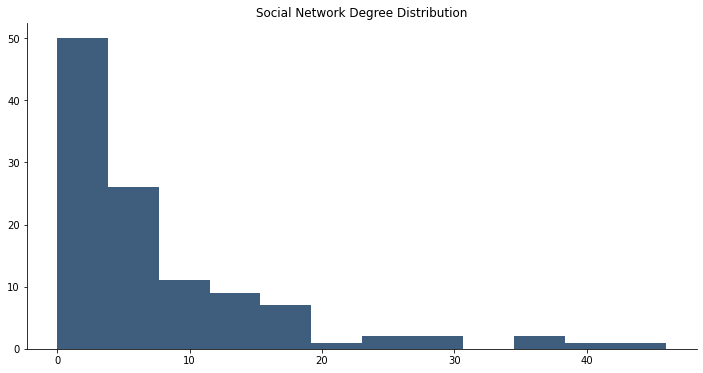

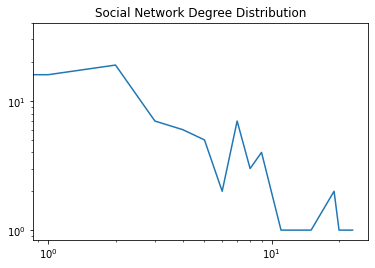

In [95]:
# Generic graphs data
N, K = graph.order(), graph.size()
avg_deg = float(K) / N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(graph))
print("WCC: ", nx.number_weakly_connected_components(graph))


degs = [i[1] for i in graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto')
plt.title("Social Network Degree Distribution")

degs = {}
for n, d in graph.in_degree():
    if d not in degs:
        degs[d] = 0
    degs[d] += 1
items = sorted(degs.items())
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot([k for (k,v) in items], [v for (k, v) in items ])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Social Network Degree Distribution")

# Degree distribution of Followers Network graph

Nodes:  78
Edges:  195
Average degree:  2.5
SCC:  26
WCC:  1


Text(0.5, 1.0, 'Followers Network Degree Distribution')

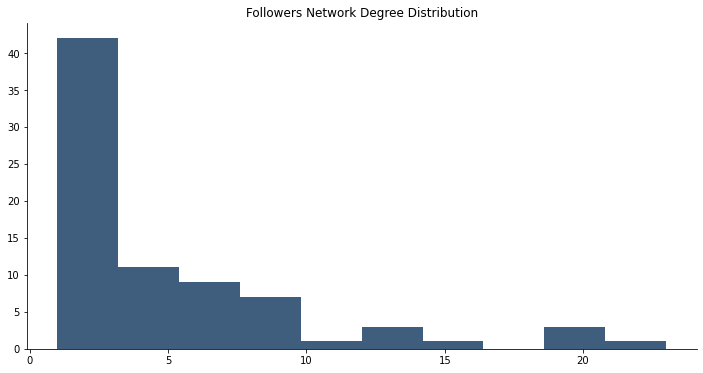

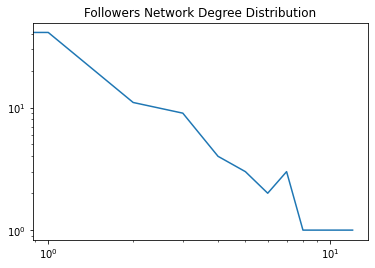

In [96]:
# Generic graphs data
N, K = followers_graph.order(), followers_graph.size()
avg_deg = float(K) / N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(followers_graph))
print("WCC: ", nx.number_weakly_connected_components(followers_graph))


degs = [i[1] for i in followers_graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto')
plt.title("Followers Network Degree Distribution")

degs = {}
for n, d in followers_graph.in_degree():
    if d not in degs:
        degs[d] = 0
    degs[d] += 1
items = sorted(degs.items())
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot([k for (k,v) in items], [v for (k, v) in items ])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Followers Network Degree Distribution")

# Degree distribution of Following Network graph

Nodes:  78
Edges:  196
Average degree:  2.5128205128205128
SCC:  26
WCC:  1


Text(0.5, 1.0, 'Following Network Degree Distribution')

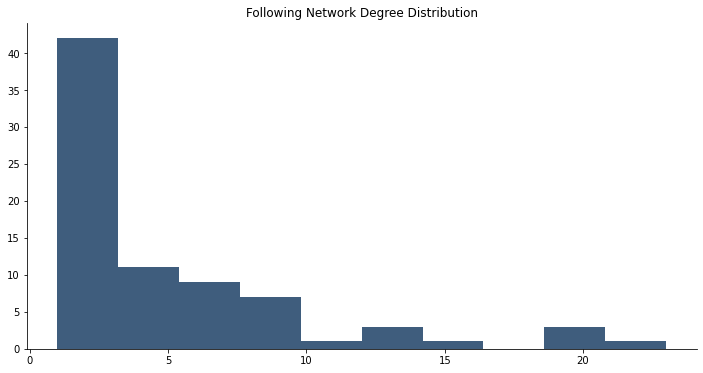

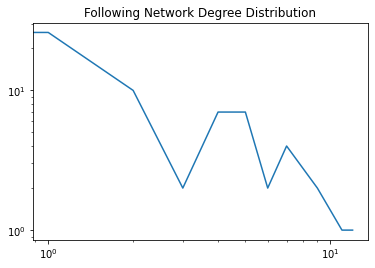

In [99]:
# Generic graphs data
N, K = following_graph.order(), following_graph.size()
avg_deg = float(K) / N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(following_graph))
print("WCC: ", nx.number_weakly_connected_components(following_graph))


degs = [i[1] for i in following_graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto')
plt.title("Following Network Degree Distribution")

degs = {}
for n, d in following_graph.in_degree():
    if d not in degs:
        degs[d] = 0
    degs[d] += 1
items = sorted(degs.items())
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot([k for (k,v) in items], [v for (k, v) in items ])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Following Network Degree Distribution")

# Clustering coefficient of Social Network graph

In [114]:
# We can get the clustering coefficient of all the nodes, but first 
# we need to convert the graph to an undirected one.
# Clustering function works only on DiGraph, so graph MUST be converted to DiGraph
graph_ud = nx.DiGraph(graph).to_undirected()

# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(graph_ud)

# Average clustering coefficient
avg_clust_coef = nx.average_clustering(graph_ud)
print("Average clustering: ", avg_clust_coef)

Average clustering:  0.19195774463631604


# Clustering coefficient of Followers Network graph

In [115]:
# We can get the clustering coefficient of all the nodes, but first 
# we need to convert the graph to an undirected one.
# Clustering function works only on DiGraph, so graph MUST be converted to DiGraph
followers_graph_ud = nx.DiGraph(followers_graph).to_undirected()

# Clustering coefficient of all nodes (in a dictionary)
followers_clust_coefficients = nx.clustering(followers_graph_ud)

# Average clustering coefficient
followers_avg_clust_coef = nx.average_clustering(followers_graph_ud)
print("Average clustering: ", followers_avg_clust_coef)

Average clustering:  0.2827322250399173


# Clustering coefficient of Following Network graph

In [116]:
# We can get the clustering coefficient of all the nodes, but first 
# we need to convert the graph to an undirected one.
# Clustering function works only on DiGraph, so graph MUST be converted to DiGraph
following_graph_ud = nx.DiGraph(following_graph).to_undirected()

# Clustering coefficient of all nodes (in a dictionary)
following_clust_coefficients = nx.clustering(following_graph_ud)

# Average clustering coefficient
following_avg_clust_coef = nx.average_clustering(following_graph_ud)
print("Average clustering: ", following_avg_clust_coef)

Average clustering:  0.27563163332394097


# Center, Radius, Average and Maximum distance of Social Network Graph

In [125]:
# To compute center, digraph must be strongly connected: we MUST use the largest connected component
# Connected components are sorted in descending order of their size
graph_components = nx.connected_components(graph_ud)
# We want the largest connected component, it’s more efficient to use max instead of sort.
graph_mc = max(graph_components, key=len)
graph_mc_sub = graph_ud.subgraph(graph_mc)

# Center : This is the set of nodes whose eccentricity is equal to the radius of the graph.
graph_center_nodes = nx.center(graph_mc_sub)
graph_center_node1_username = graph_mc_sub.nodes[graph_center_nodes[0]]['username']
graph_center_node2_username = graph_mc_sub.nodes[graph_center_nodes[1]]['username']
print("Center nodes: {} - {}".format(graph_center_node1_username, graph_center_node2_username))

# radius is the minimum eccentricity in a graph.
print("Radius: ", nx.radius(graph_mc_sub))

# average of the distances between ever pair of nodes.
print("Average distance: ", nx.average_shortest_path_length(graph_mc_sub))

# The diameter of a graph is the maximum distance between any of the pairs of nodes.
print("Maximum distance: ", nx.diameter(graph_mc_sub))

Center nodes: mizzaro - acai2021
Radius:  4
Average distance:  3.8504828504828503
Maximum distance:  7


# Center, Radius, Average and Maximum distance of Followers Network Graph

In [127]:
# To compute center, digraph must be strongly connected: we MUST use the largest connected component
# Connected components are sorted in descending order of their size
followers_graph_components = nx.connected_components(followers_graph_ud)
# We want the largest connected component, it’s more efficient to use max instead of sort.
followers_graph_mc = max(followers_graph_components, key=len)
followers_graph_mc_sub = followers_graph_ud.subgraph(followers_graph_mc)

# Center : This is the set of nodes whose eccentricity is equal to the radius of the graph.
followers_graph_center_nodes = nx.center(followers_graph_mc_sub)
followers_graph_center_node1_username = followers_graph_mc_sub.nodes[followers_graph_center_nodes[0]]['username']
followers_graph_center_node2_username = followers_graph_mc_sub.nodes[followers_graph_center_nodes[1]]['username']
print("Center nodes: {} - {}".format(followers_graph_center_node1_username, followers_graph_center_node2_username))

# radius is the minimum eccentricity in a graph.
print("Radius: ", nx.radius(followers_graph_mc_sub))

# average of the distances between ever pair of nodes.
print("Average distance: ", nx.average_shortest_path_length(followers_graph_mc_sub))

# The diameter of a graph is the maximum distance between any of the pairs of nodes.
print("Maximum distance: ", nx.diameter(followers_graph_mc_sub))

Center nodes: mizzaro - acai2021
Radius:  4
Average distance:  3.850815850815851
Maximum distance:  7


# Center, Radius, Average and Maximum distance of Following Network Graph

In [128]:
# To compute center, digraph must be strongly connected: we MUST use the largest connected component
# Connected components are sorted in descending order of their size
following_graph_components = nx.connected_components(following_graph_ud)
# We want the largest connected component, it’s more efficient to use max instead of sort.
following_graph_mc = max(following_graph_components, key=len)
following_graph_mc_sub = following_graph_ud.subgraph(graph_mc)

# Center : This is the set of nodes whose eccentricity is equal to the radius of the graph.
following_graph_center_nodes = nx.center(following_graph_mc_sub)
following_graph_center_node1_username = following_graph_mc_sub.nodes[following_graph_center_nodes[0]]['username']
following_graph_center_node2_username = following_graph_mc_sub.nodes[following_graph_center_nodes[1]]['username']
print("Center nodes: {} - {}".format(following_graph_center_node1_username, following_graph_center_node2_username))

# radius is the minimum eccentricity in a graph.
print("Radius: ", nx.radius(following_graph_mc_sub))

# average of the distances between ever pair of nodes.
print("Average distance: ", nx.average_shortest_path_length(following_graph_mc_sub))

# The diameter of a graph is the maximum distance between any of the pairs of nodes.
print("Maximum distance: ", nx.diameter(following_graph_mc_sub))

Center nodes: mizzaro - acai2021
Radius:  4
Average distance:  3.8504828504828503
Maximum distance:  7


We will first extract the largest connected component and then compute the 
node centrality measures

12. Calcolate le seguenti misure di centralità sui grafi:
-  Betweenness centrality
- Closeness centrality
- Degree centrality
- In-degree centrality
- Out-degree centrality
- Page Rank
- HITS

In [150]:
# To compute center, digraph must be strongly connected: we MUST use the largest connected component
# Connected components are sorted in descending order of their size
graph_di_components = nx.connected_components(graph)
#print(graph_di_components)

# We want the largest connected component, it’s more efficient to use max instead of sort.
#graph_di_mc = max(graph_di_components, key=len)
#graph_di_mc_sub = graph_ud.subgraph(graph_di_mc)


# Betweenness centrality
graph_bet_cen = nx.betweenness_centrality(graph_mc_sub)

# Closeness centrality
graph_clo_cen = nx.closeness_centrality(graph_mc_sub)

# Compute the degree centrality for nodes.
graph_deg_cen = nx.degree_centrality(graph_mc_sub)

# Compute the in-degree centrality for nodes.
graph_in_deg_cen = nx.in_degree_centrality(graph)

# Compute the out-degree centrality for nodes.
graph_out_deg_cen = nx.out_degree_centrality(graph)

# PageRank of the nodes in the graph.
graph_page_rank = nx.pagerank(graph_mc_sub)

# HITS hubs and authorities values for nodes.
graph_hits = nx.hits(graph)


<generator object connected_components at 0x7fb7d1b253c0>


13. Calcolate i seguenti coefficienti per stimare la “small-world-ness” dei grafi:
- Coefficiente omega
- Coefficiente sigma

In [111]:
# Omega
# The small-world coefficient (omega) ranges between -1 and 1.
# Values close to 0 means the G features small-world characteristics.
# Values close to -1 means G has a lattice shape whereas values close to 1 means G is a random graph.

omega = nx.algorithms.smallworld.omega(cam_net_mc_sub)

# Sigma
# A graph is commonly classified as small-world if sigma>1.
sigma = nx.algorithms.smallworld.sigma(cam_net_mc_sub)


Calcolare le correlazioni di Pearson e Kendall fra le misure di centralità; riportare il
risultato in due tabelle

In [141]:
df_bet_cen = pd.DataFrame(graph_bet_cen.items(), columns=['ID', 'Betweenness'])
df_clo_cen = pd.DataFrame(graph_clo_cen.items(), columns=['ID', 'Closeness'])
df_deg_cen = pd.DataFrame(graph_deg_cen.items(), columns=['ID', 'Degree'])
df_in_deg_cen = pd.DataFrame(graph_in_deg_cen.items(), columns=['ID', 'In-Degree'])
df_out_deg_cen = pd.DataFrame(graph_out_deg_cen.items(), columns=['ID', 'Out-Degree'])

result = pd.merge(df_bet_cen, df_clo_cen, on=['ID'])
result = pd.merge(result, df_deg_cen, on=['ID'])
result = pd.merge(result, df_in_deg_cen, on=['ID'])
result = pd.merge(result, df_out_deg_cen, on=['ID'])

display(result.corr(method ='pearson'))


# To find the correlation among
# the columns using kendall method
display(result.corr(method ='kendall'))

,Betweenness,Closeness,Degree,In-Degree,Out-Degree
Betweenness,1.000000,0.771277,0.506234,0.506449,0.505883
Closeness,0.771277,1.000000,0.676626,0.677028,0.676042
Degree,0.506234,0.676626,1.000000,0.999865,0.999866
In-Degree,0.506449,0.677028,0.999865,1.000000,0.999461
Out-Degree,0.505883,0.676042,0.999866,0.999461,1.000000


,Betweenness,Closeness,Degree,In-Degree,Out-Degree
Betweenness,1.000000,0.573237,0.729591,0.730722,0.726551
Closeness,0.573237,1.000000,0.503553,0.504392,0.501538
Degree,0.729591,0.503553,1.000000,0.999052,0.997534
In-Degree,0.730722,0.504392,0.999052,1.000000,0.996579
Out-Degree,0.726551,0.501538,0.997534,0.996579,1.000000
